Using TensorFlow backend.


Note: response values were scaled by multiplying by 1.0000000000 and adding 0.000000
Epoch 1/5
159/159 [==============================] - 0s 3ms/step - loss: 0.3627 - accuracy: 0.5660
Epoch 2/5
159/159 [==============================] - 0s 117us/step - loss: 0.3121 - accuracy: 0.5660
Epoch 3/5
159/159 [==============================] - 0s 175us/step - loss: 0.2918 - accuracy: 0.5094
Epoch 4/5
159/159 [==============================] - 0s 133us/step - loss: 0.2851 - accuracy: 0.4780
Epoch 5/5
159/159 [==============================] - 0s 122us/step - loss: 0.2870 - accuracy: 0.4214
[0.6125209  0.41486114 0.24925983 0.24116732 0.3414573  0.47408175
 0.42577586 0.4223027  0.33719128 0.3547866  0.44122282 0.32192373
 0.37848198 0.32836136 0.45246577 0.36964908 0.43036097 0.37067255
 0.30761144 0.34973803 0.44540802 0.4456979  0.41563553 0.34460062
 0.32717487 0.38417184 0.48843908 0.38998976 0.3829661  0.3781769
 0.5914432  0.43713856 0.31992206 0.41164628 0.3497699  0.44045085
 0.586438  

/home/sanju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


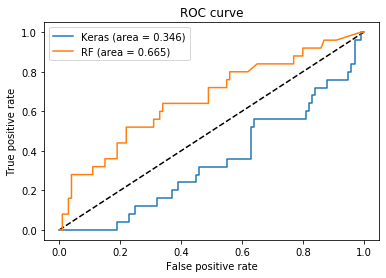

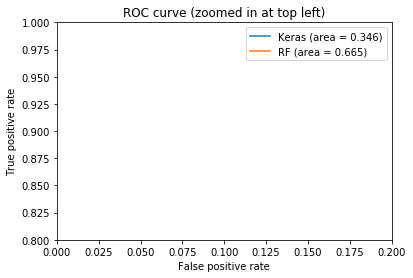

In [1]:
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
np.random.seed(2020)
import random
random.seed(47)

# Load training data set from CSV file
training_data_df = pd.read_csv("training-data.csv", index_col=0)
training_data_df = training_data_df.drop('responsenstage', axis=1)
training_data_df.head()

# Load testing data set from CSV file
test_data_df = pd.read_csv("testing-data.csv", index_col=0)
test_data_df = test_data_df.drop('responsenstage', axis=1)
test_data_df.head()

# Convert response data in 0 and 1
response_num = {'nonresponder': 0, 'responder': 1}
training_data_df['response'] = training_data_df['response'].map(response_num)
test_data_df['response'] = test_data_df['response'].map(response_num)

# Data needs to be scaled to a small range like 0 to 1 for the neural
# network to work well.
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale both the training inputs and outputs
scaled_training =scaler.fit_transform(training_data_df)
scaled_testing = scaler.transform(test_data_df)

# Print out the adjustment that the scaler applied to the total_earnings column of data
print("Note: response values were scaled by multiplying by {:.10f} and adding {:.6f}".format(scaler.scale_[125], scaler.min_[125]))

# Create new pandas DataFrame objects from the scaled data
scaled_training_df = pd.DataFrame(scaled_training, columns=training_data_df.columns.values)
scaled_testing_df = pd.DataFrame(scaled_testing, columns=test_data_df.columns.values)

# Save scaled data dataframes to new CSV files
scaled_training_df.to_csv("sales_data_training_scaled.csv", index=0)
scaled_testing_df.to_csv("sales_data_testing_scaled.csv", index=0)








RUN_NAME = "run 2 with 5 nodes"

training_data_df = pd.read_csv("sales_data_training_scaled.csv")

X = training_data_df.drop('response', axis=1).values
Y = training_data_df[['response']].values

# Define the model
def build_model():
    model = Sequential()
    model.add(Dense(5, input_dim=125, activation='relu', name='layer_1'))
    model.add(Dense(100, activation='relu', name='layer_2'))
    model.add(Dense(50, activation='relu', name='layer_3'))
    model.add(Dense(1, activation='linear', name='output_layer'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])
    return model

# Create a TensorBoard logger
logger = keras.callbacks.TensorBoard(
    log_dir='logs/{}'.format(RUN_NAME),
    histogram_freq=5,
    write_graph=True
)

## this part is for k-fold cross validation accuracy
#estimators = []
#estimators.append(('standardize', StandardScaler()))
#estimators.append(('mlp', KerasClassifier(build_fn=build_model, epochs=100, batch_size=5, verbose=0)))
#pipeline = Pipeline(estimators)
#kfold = StratifiedKFold(n_splits=10, shuffle=True)
#results = cross_val_score(pipeline, X, Y, cv=kfold)
#print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

## Fit Model
from keras.wrappers.scikit_learn import KerasClassifier
keras_model = build_model()
keras_model.fit(X, Y, epochs=5, batch_size=100, verbose=1)

# Load the separate test data set
test_data_df = pd.read_csv("sales_data_testing_scaled.csv")
X_test = test_data_df.drop('response', axis=1).values
Y_test = test_data_df[['response']].values

## ROC Curve
from sklearn.metrics import roc_curve
y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print(y_pred_keras)


## Make a random forest model from sklear
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X, Y)
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)
print(y_pred_rf)

print(auc_rf, auc_keras)


## Print ROC Curve
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()


